In [3]:
import pandas as pd

df = pd.read_excel("Online Retail.xlsx")
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Remove missing CustomerIDs
df.dropna(subset=['CustomerID'], inplace=True)

# Filter only positive Quantity
df = df[df['Quantity'] > 0]

# Create TotalPrice column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


/tmp/ipython-input-4-4185569907.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['TotalPrice'] = df['Quantity'] * df['UnitPrice']


In [5]:
import datetime

# Define snapshot date
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# RFM aggregation
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])


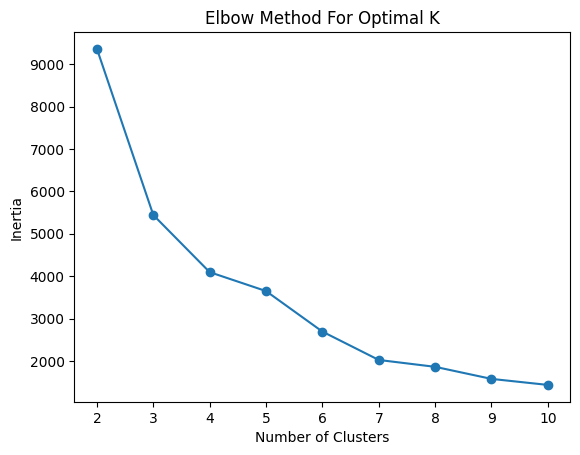

In [7]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method
inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(range(2, 11), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal K')
plt.show()


In [8]:
# Final model
kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)


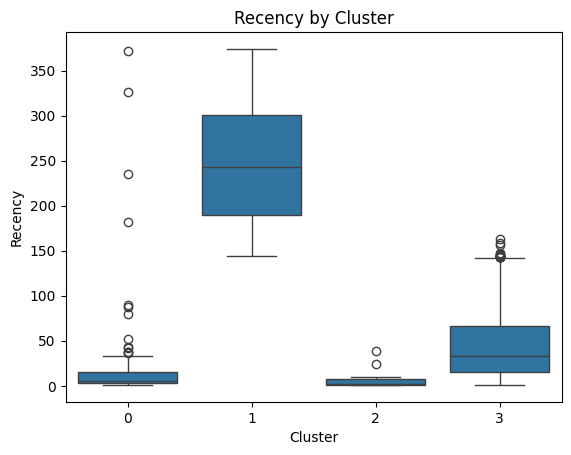

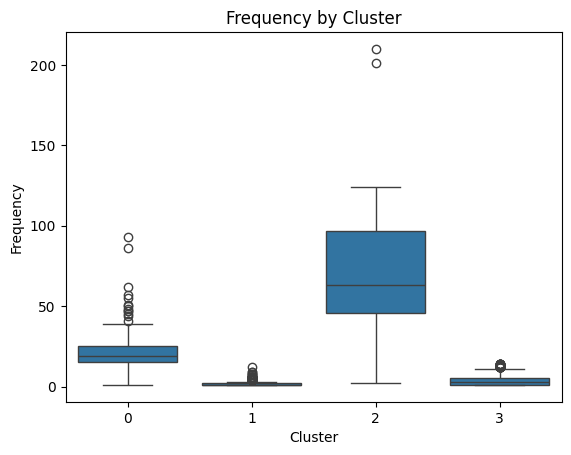

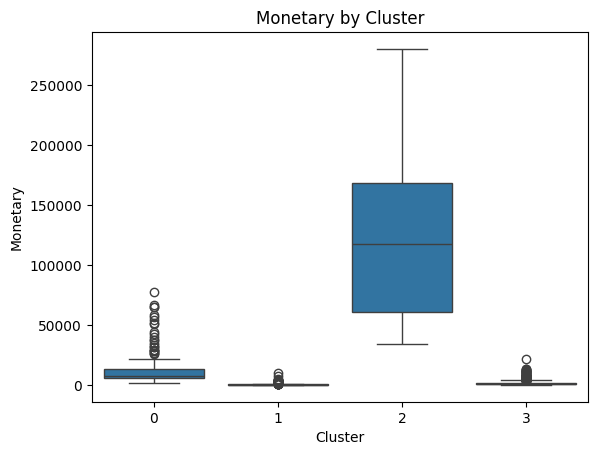

In [13]:
import seaborn as sns

# Boxplots
sns.boxplot(x='Cluster', y='Recency', data=rfm)
plt.title("Recency by Cluster")
plt.show()

sns.boxplot(x='Cluster', y='Frequency', data=rfm)
plt.title("Frequency by Cluster")
plt.show()

sns.boxplot(x='Cluster', y='Monetary', data=rfm)
plt.title("Monetary by Cluster")
plt.show()


In [14]:
# Summary of clusters
rfm.groupby('Cluster').mean()


,CustomerID,Recency,Frequency,Monetary
Cluster,,,,
0,15201.928910,15.672986,22.047393,12453.225924
1,15344.258004,248.564030,1.551789,478.107581
2,15435.000000,7.384615,82.692308,127338.313846
3,15290.717982,43.910580,3.655748,1349.698298


In [15]:
rfm.to_csv("Segmented_Customers.csv", index=False)
